Import package and path

In [4]:
import os
import json
import xarray as xr
import numpy as np
import matplotlib as plt
from datetime import datetime


from qcat.utility.file_structure import *
from qcat.utility.io_translator import *
# from analysis.analysis_method import *
from qcat.visualization.photon_dep_loss import * 

root_fd = r"C:\Users\Ke Lab\SynologyDrive\09 Data\Fridge Data\Qubit\20241101_DR4_6SQpb+AS1604\dummy"
raw_data_fd = f"{root_fd}\\raw"
preprocess_data_fd = f"{root_fd}\\preprocess"
plot_data_fd = f"{root_fd}\\result"
output_fd = f"{root_fd}\\result"


Format convert ( LiteVNA )

In [5]:
from qcat.utility.file_structure import create_subfolder


# Get all resonator from folder
resonator_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

print(resonator_list)

for resonator_label in resonator_list:

    print(f"{resonator_label}")
    resonator_fd = f"{raw_data_fd}\\{resonator_label}"
    power_list = [d for d in os.listdir(resonator_fd) if os.path.isdir(os.path.join(resonator_fd, d))]

    create_subfolder(preprocess_data_fd,resonator_label)
    ave_resonator_folder = f"{preprocess_data_fd}\\{resonator_label}" 

    for power_label in power_list:

        # print(f"{resonator_label} {power_label}")

        power_fd = f"{resonator_fd}\\{power_label}"
        file_list = [d for d in os.listdir(power_fd) ]
        file_number = len(file_list)
        print( f"{file_number} files in {power_label}" )
        
        same_power_data = []
        
        for i, f_name in enumerate(file_list):

            # Read data
            # print(f"{i+1}/{file_number} {f_name}")
            file_fullpath = f"{power_fd}\\{f_name}"
            dataset = xr.open_dataset(file_fullpath)

            # Parse the time strings back to datetime objects
            start_time = datetime.strptime(dataset.attrs["start_time"], "%Y%m%d_%H%M%S")
            end_time = datetime.strptime(dataset.attrs["end_time"], "%Y%m%d_%H%M%S")
            if i==0: 
                start_time_all = start_time
                end_time_all = end_time
            if start_time < start_time_all : start_time_all = start_time
            if end_time > end_time_all : end_time_all = end_time_all


            power = dataset.attrs["power"]
            attenuation = dataset.attrs["attenuation"]
            # attenuation = 105

            frequency = dataset.coords["frequency"]
            same_power_data.append(dataset["s21"].values)

        # print(same_power_data)
        same_power_data = np.array(same_power_data)
        print(same_power_data.ndim)
        if same_power_data.ndim == 3:
            ave_data = np.mean( np.array(same_power_data), axis=0 )
        else:
            ave_data = same_power_data
        # print(ave_data)
        # Creating an xarray dataset
        output_data = {
            "s21": ( ["s_params","frequency"],
                    np.array([ave_data[0], ave_data[1]]) )
        }
        dataset = xr.Dataset(
            output_data,
            coords={ "s_params":np.array(["real","imag"]), "frequency": frequency })

        dataset.attrs["power"] = power
        dataset.attrs["attenuation"] = int(attenuation)
        dataset.attrs["start_time"] = str(start_time.strftime("%Y%m%d_%H%M%S"))
        dataset.attrs["end_time"] = str(end_time.strftime("%Y%m%d_%H%M%S"))
        # print(dataset)
        dataset.to_netcdf(f"{ave_resonator_folder}\\liteVNA_{str(attenuation)}_{str(power)}.nc")


['C49837']
C49837
1 files in att110_-10.0
3
1 files in att110_-20.0
3
1 files in att110_-30.0
3
10 files in att110_-40.0
3
100 files in att110_-50.0
3
100 files in att110_-60.0
3
1 files in att110_0.0
3
1 files in att80_-10.0
3
1 files in att80_-20.0
3
1 files in att80_-30.0
3
1 files in att80_-40.0
3
1 files in att80_-50.0
3
1 files in att80_-60.0
3
1 files in att80_0.0
3


Format convert ( QM )

In [6]:
from qcat.utility.file_structure import create_subfolder


raw_data_fd = r"d:\Data\resonator\5Q4C"
preprocess_data_fd = r"d:\Data\resonator\5Q4C\fit_data_pd\q4_min"
# Get all resonator from folder
# resonator_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

f_name = "20240626_1504_power_dep_resonator_q4_ro_min.nc"
freq_ref = 5900 -166.6+10+1.36-1.11+1.49-3.38
ro_name = "q4_ro"

# Read data
# print(f"{i+1}/{file_number} {f_name}")
file_fullpath = f"{raw_data_fd}\\{f_name}"
dataset = xr.open_dataset(file_fullpath)
# dataset = dataset.transpose( "amp_ratio", "mixer", "frequency" )
print( dataset )
# Parse the time strings back to datetime objects
start_time = datetime.strptime(dataset.attrs["start_time"], "%Y%m%d_%H%M%S")
end_time = datetime.strptime(dataset.attrs["end_time"], "%Y%m%d_%H%M%S")
amp_ratio = dataset.coords["amp_ratio"].values
print(amp_ratio)
power_list = 0 +20*np.log10(amp_ratio)
attenuation = 0
print(power_list)
ave_data = dataset[ro_name].values

frequency = (dataset.coords["frequency"].values +freq_ref)*1e6
print( frequency )

temp_idx = ( 100, -100 )
for i, power_label in enumerate(power_list):

    print(power_label)
    # Creating an xarray dataset
    output_data = {
        "s21": ( ["s_params","frequency"],
                np.array([ave_data[0][i][temp_idx[0]:temp_idx[1]], ave_data[1][i][temp_idx[0]:temp_idx[1]]]) )
    }
    output_dataset = xr.Dataset(
        output_data,
        coords={ "s_params":np.array(["real","imag"]), "frequency": frequency[temp_idx[0]:temp_idx[1]] })

    output_dataset.attrs["power"] = power_label
    output_dataset.attrs["attenuation"] = int(attenuation)
    output_dataset.attrs["start_time"] = str(start_time.strftime("%m%d_%H%M%S"))
    output_dataset.attrs["end_time"] = str(end_time.strftime("%m%d_%H%M%S"))
    # print(dataset)
    output_dataset.to_netcdf(f"{preprocess_data_fd}\\QM_{str(attenuation)}_{power_label:.1f}.nc")



FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'd:\Data\resonator\5Q4C\20240626_1504_power_dep_resonator_q4_ro_min.nc', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Format convert ( PYQUM )

In [ ]:
from qcat.utility.file_structure import create_subfolder


raw_data_fd = r"D:\Data\resonator\ITRI_364_scalinQ\raw"
preprocess_data_fd = r"d:\Data\resonator\ITRI_364_scalinQ_new\fit_data_pd"
# Get all resonator from folder
resonator_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

print(resonator_list)

for resonator_label in resonator_list:

    print(f"{resonator_label}")
    resonator_fd = f"{raw_data_fd}\\{resonator_label}"
    power_list = [d for d in os.listdir(resonator_fd) if os.path.isdir(os.path.join(resonator_fd, d))]

    create_subfolder(preprocess_data_fd,resonator_label)
    ave_resonator_folder = f"{preprocess_data_fd}\\{resonator_label}" 

    mat_files = check_file_extension( resonator_fd, "mat")
    df_config = pd.read_json(f'{resonator_fd}\\config.json')
    for index, row in df_config.iterrows():
        attenuation = row["attenuation"]
        file_name = row["file_name"]
        print(f"{file_name} with {attenuation} dB attenuation")
        power_list, frequency, s21 = mat_to_numpy(f"{resonator_fd}\\{file_name}")
        print(frequency[0])
        zdata_2d = s21.transpose()
        for i, power_label in enumerate(power_list):
            # print(power_label)
            data = zdata_2d[i]


            # Creating an xarray dataset
            output_data = {
                "s21": ( ["s_params","frequency"],
                        np.array([data.real, data.imag]) )
            }
            dataset = xr.Dataset(
                output_data,
                coords={ "s_params":np.array(["real","imag"]), "frequency": frequency*1e9 })
            
            dataset.attrs["attenuation"] = int(attenuation)
            dataset.attrs["power"] = power_label
            dataset.to_netcdf(f"{ave_resonator_folder}\\PYQUM_{str(attenuation)}_{str(power_label)}.nc")


FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'D:\\Data\\resonator\\ITRI_364_scalinQ\\raw'

Start Analysis

Processing C58876
C:\Users\Ke Lab\Desktop\YUHOW\5Q4C_0430_7\preprocess\C58876
['liteVNA_80_-10.0.nc', 'liteVNA_80_-20.0.nc', 'liteVNA_80_-40.0.nc', 'liteVNA_80_-50.0.nc', 'liteVNA_80_-60.0.nc', 'liteVNA_80_0.0.nc']
C58876 start free analysis
0 th
1 th
2 th
3 th
4 th
5 th
Saving plot at C:\Users\Ke Lab\Desktop\YUHOW\5Q4C_0430_7\result\C58876/C58876_free.png
delay: 6.401e-08,
amp_norm: 7.703e-01,
Qc: 4.002e+03,
alpha: 1.280e-01
Saving plot at C:\Users\Ke Lab\Desktop\YUHOW\5Q4C_0430_7\result\C58876/C58876_refined.png
Processing C59414
C:\Users\Ke Lab\Desktop\YUHOW\5Q4C_0430_7\preprocess\C59414
['liteVNA_80_-10.0.nc', 'liteVNA_80_-20.0.nc', 'liteVNA_80_-40.0.nc', 'liteVNA_80_-50.0.nc', 'liteVNA_80_-60.0.nc', 'liteVNA_80_0.0.nc']
C59414 start free analysis
0 th
1 th
2 th
3 th
4 th
5 th
Saving plot at C:\Users\Ke Lab\Desktop\YUHOW\5Q4C_0430_7\result\C59414/C59414_free.png
delay: 6.365e-08,
amp_norm: 7.938e-01,
Qc: 3.753e+03,
alpha: -7.456e-01
Saving plot at C:\Users\Ke Lab\Desktop\YUHOW\5Q4C

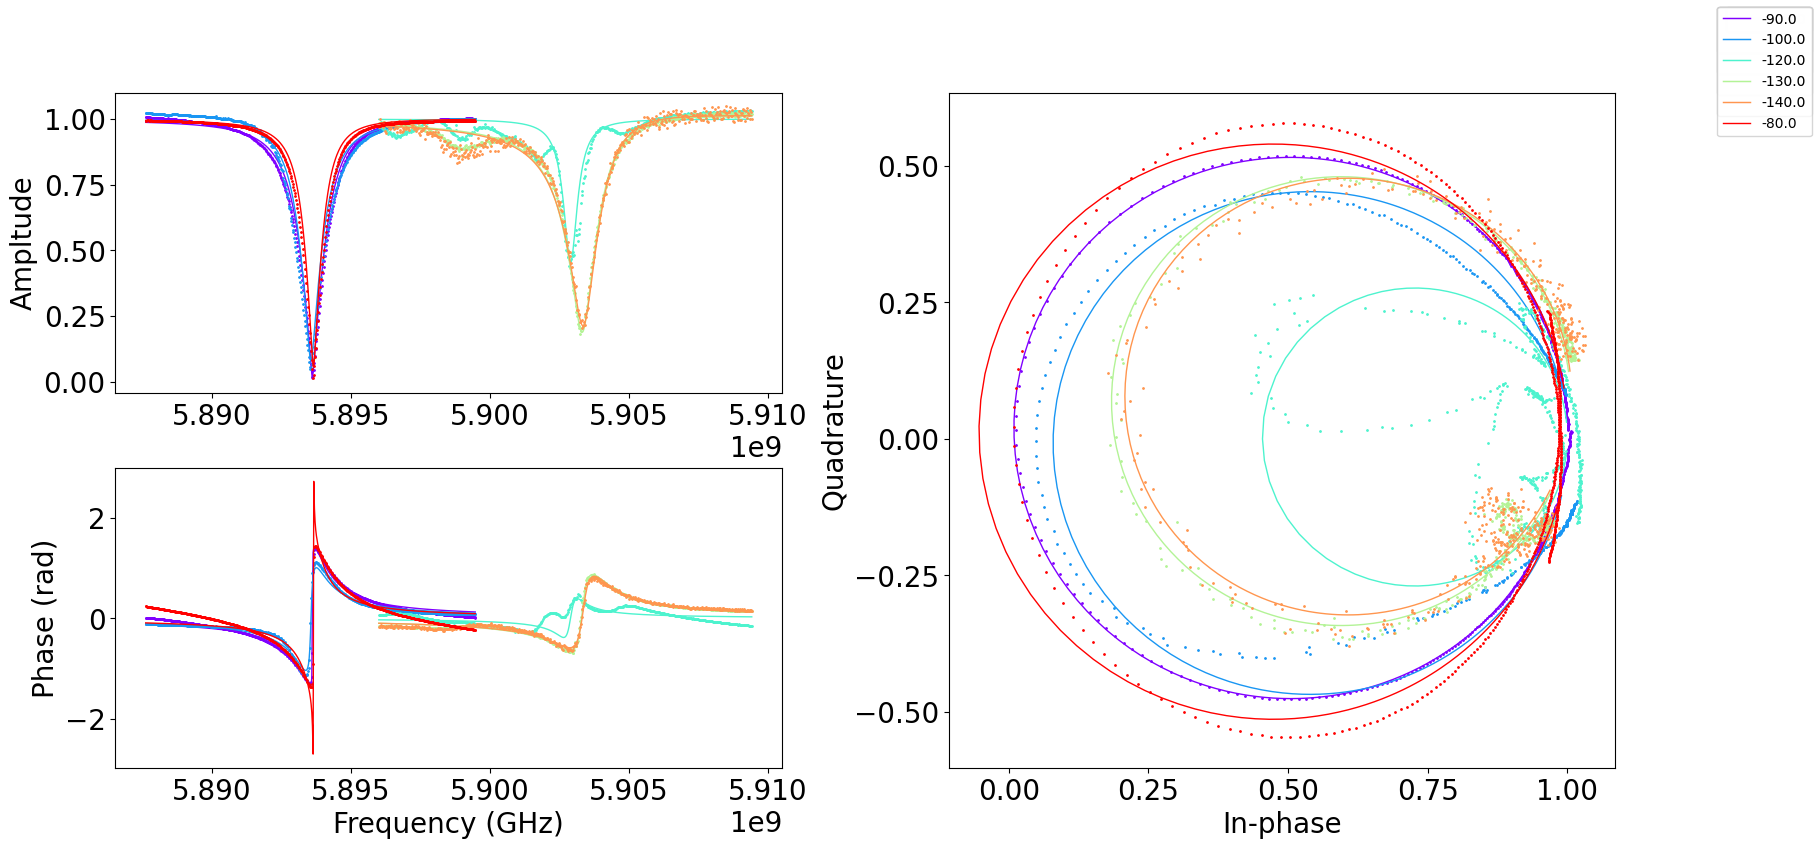

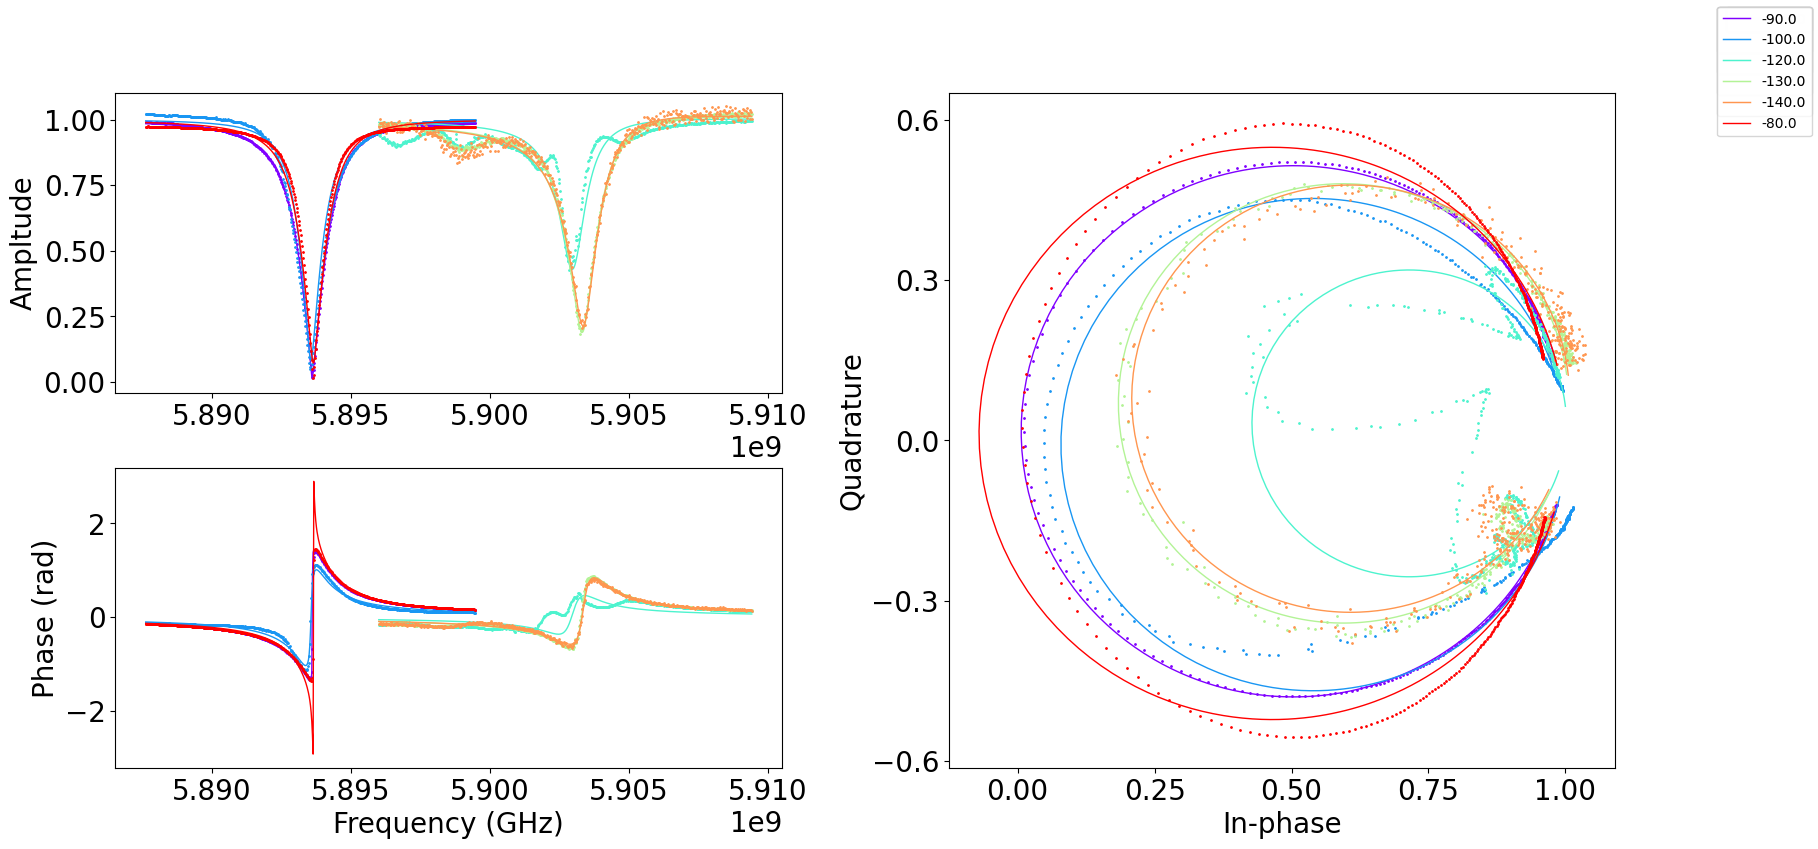

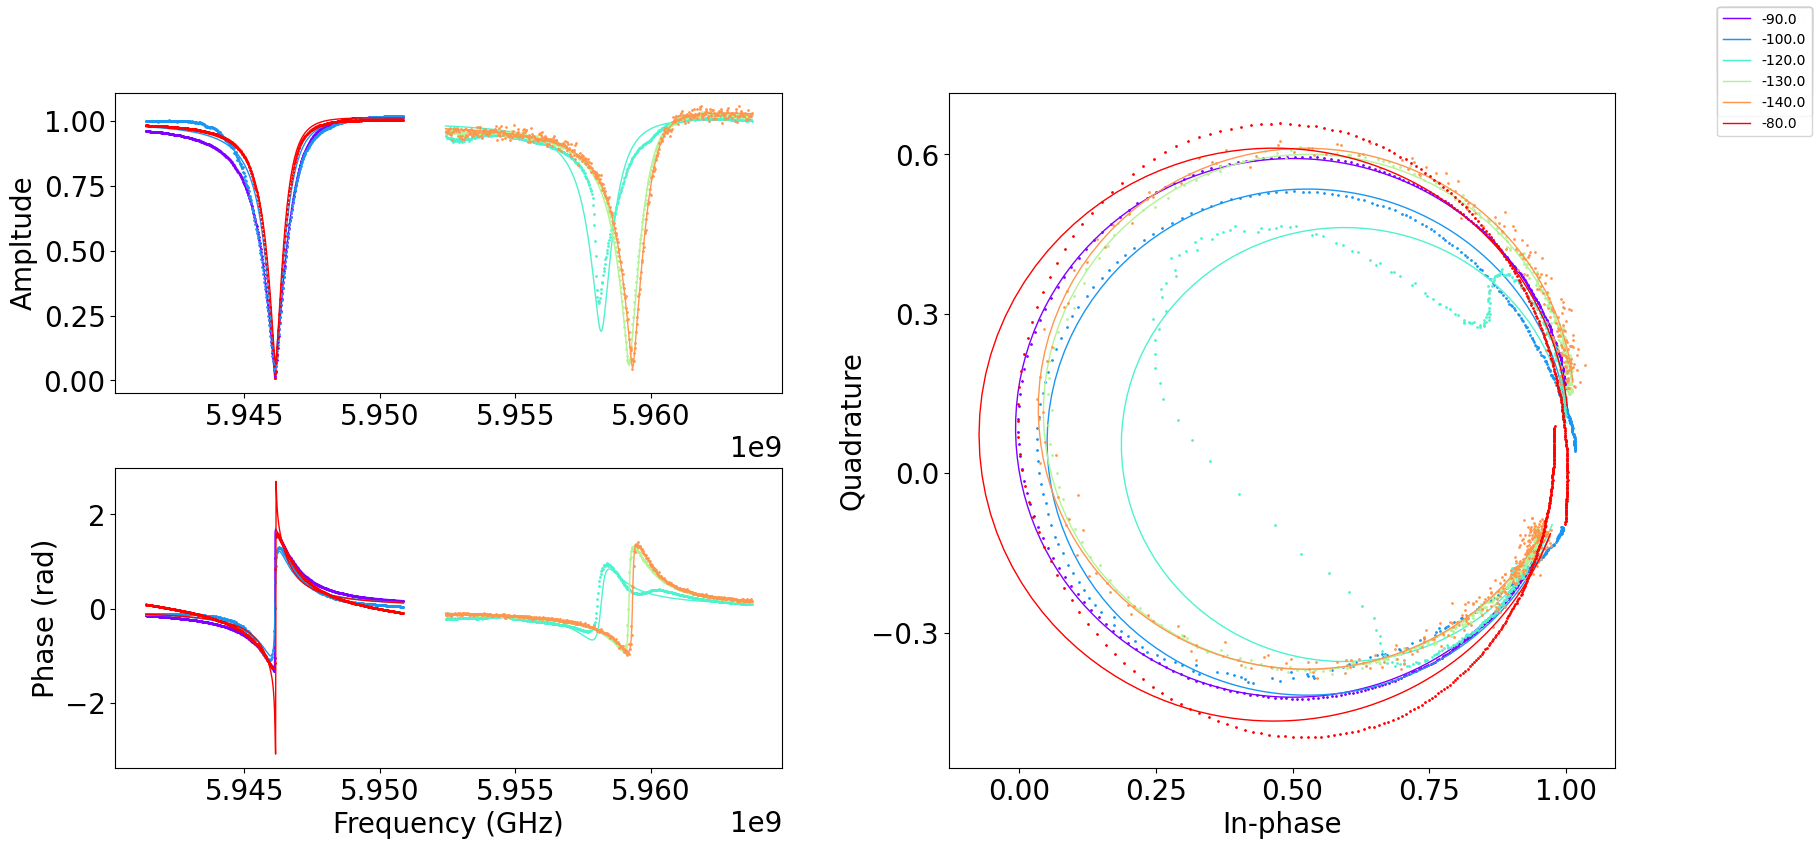

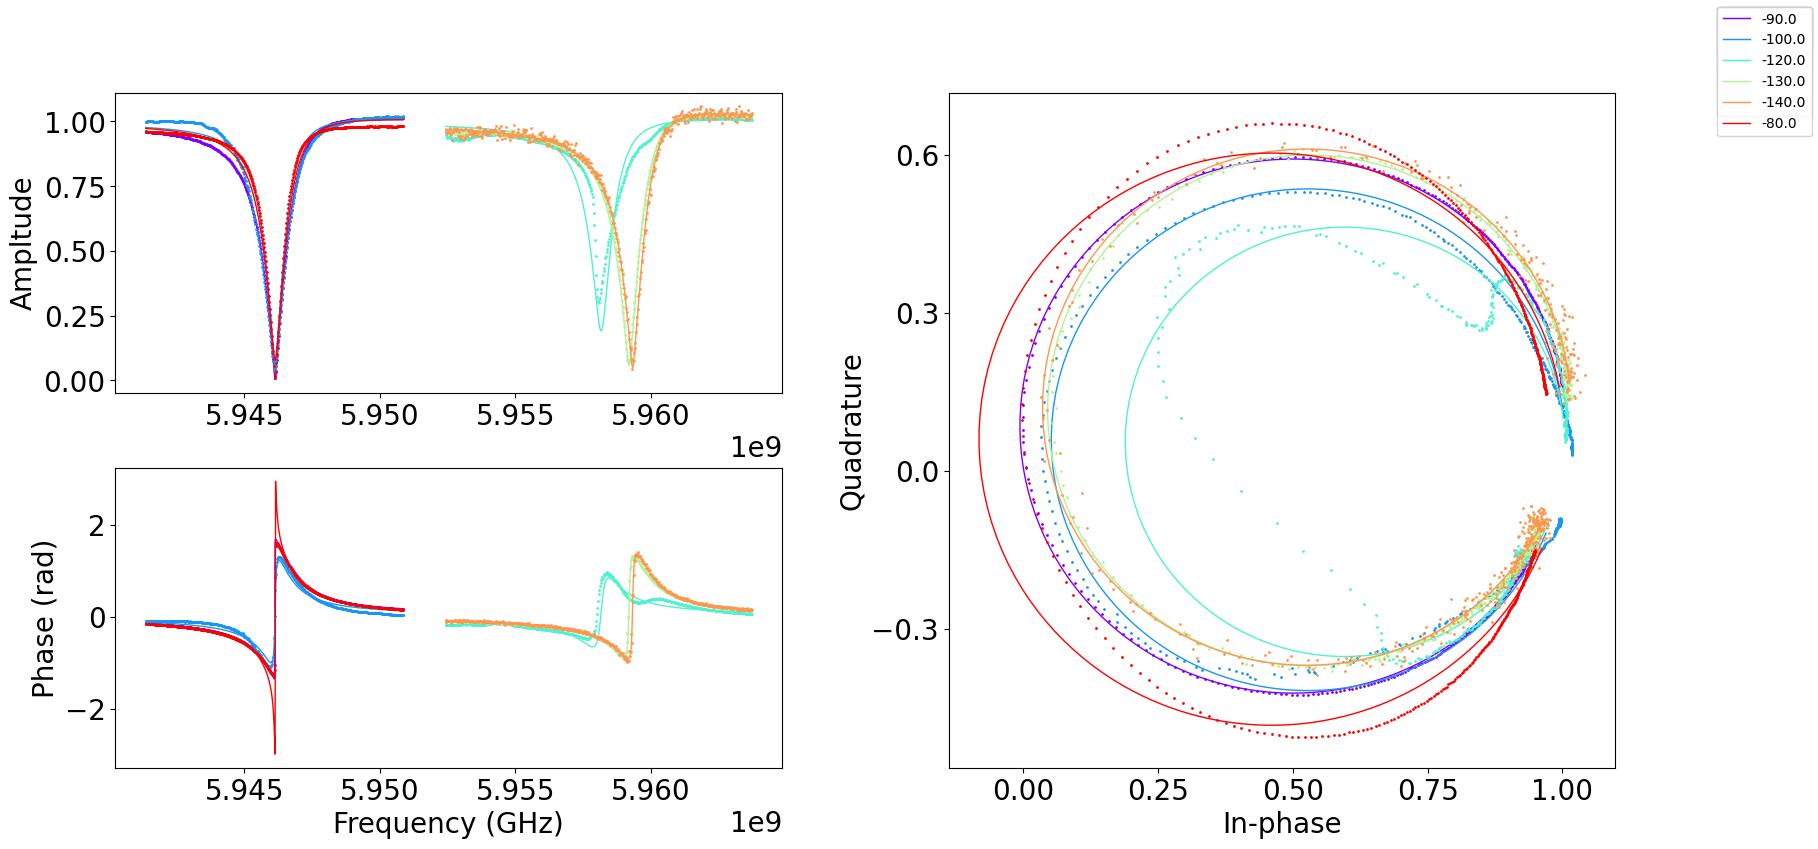

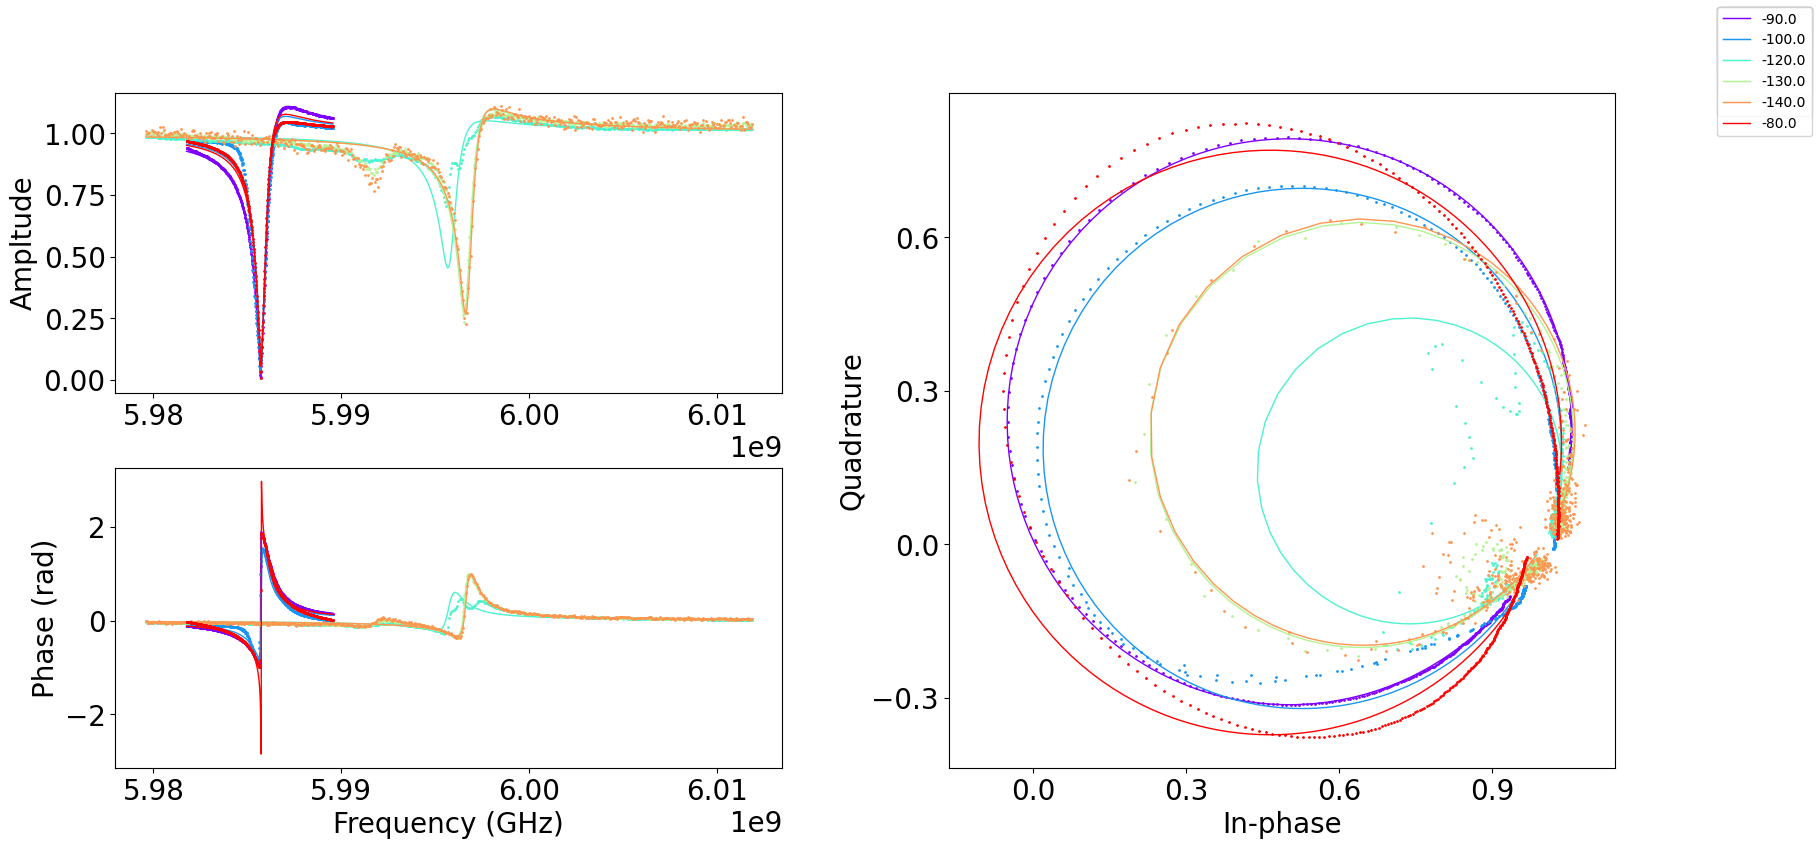

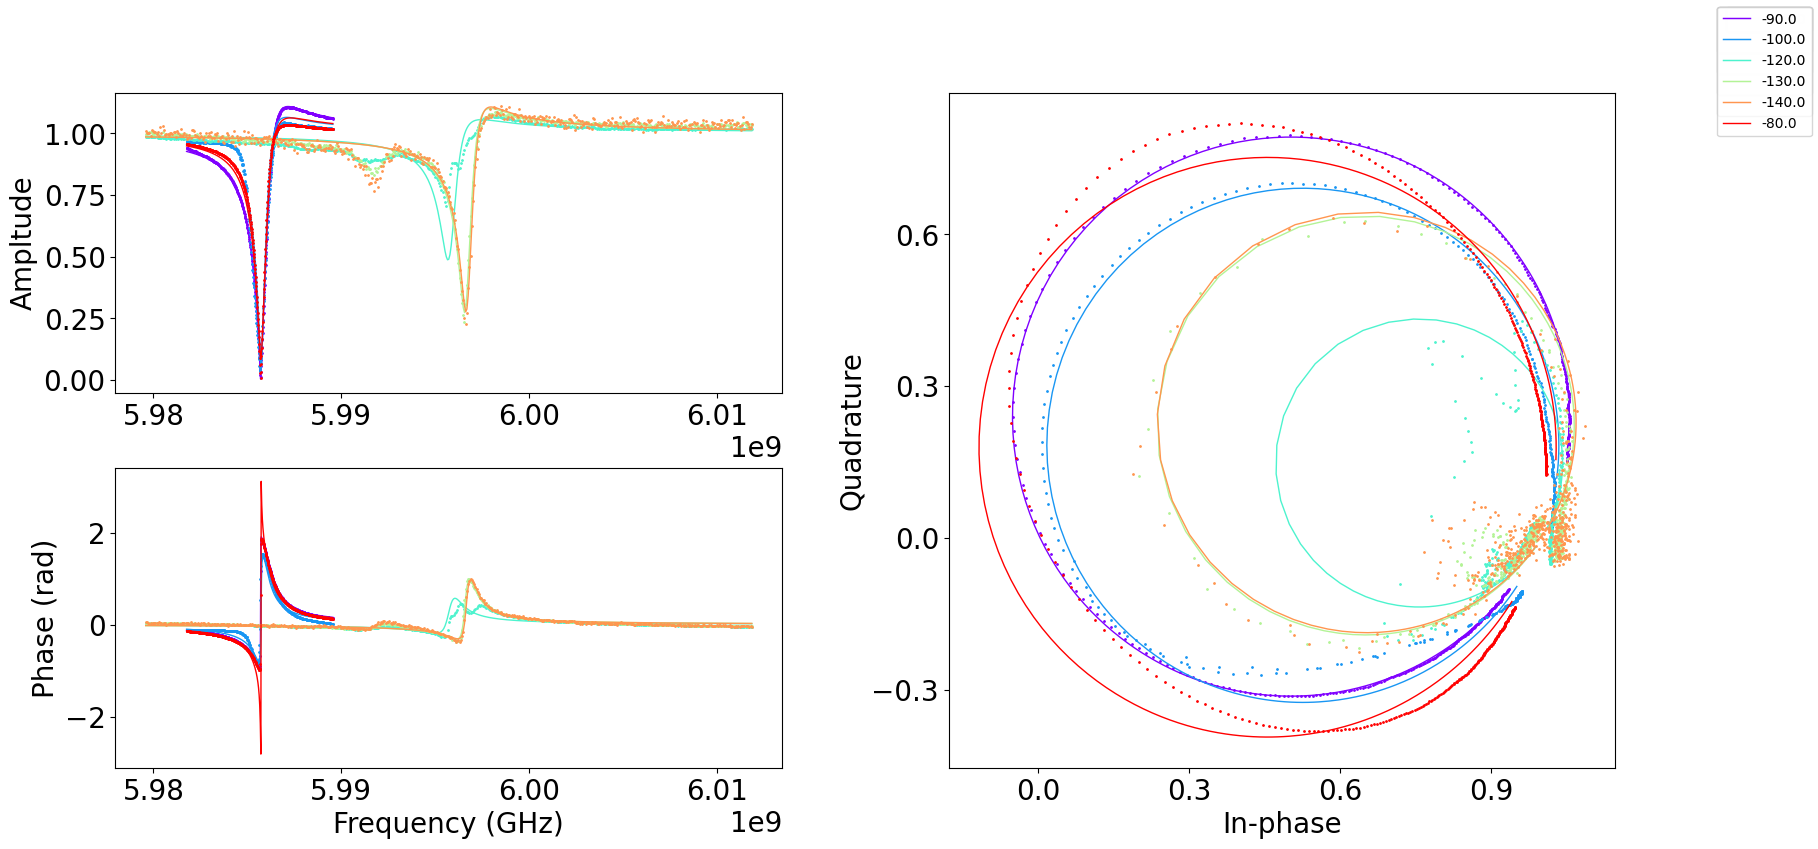

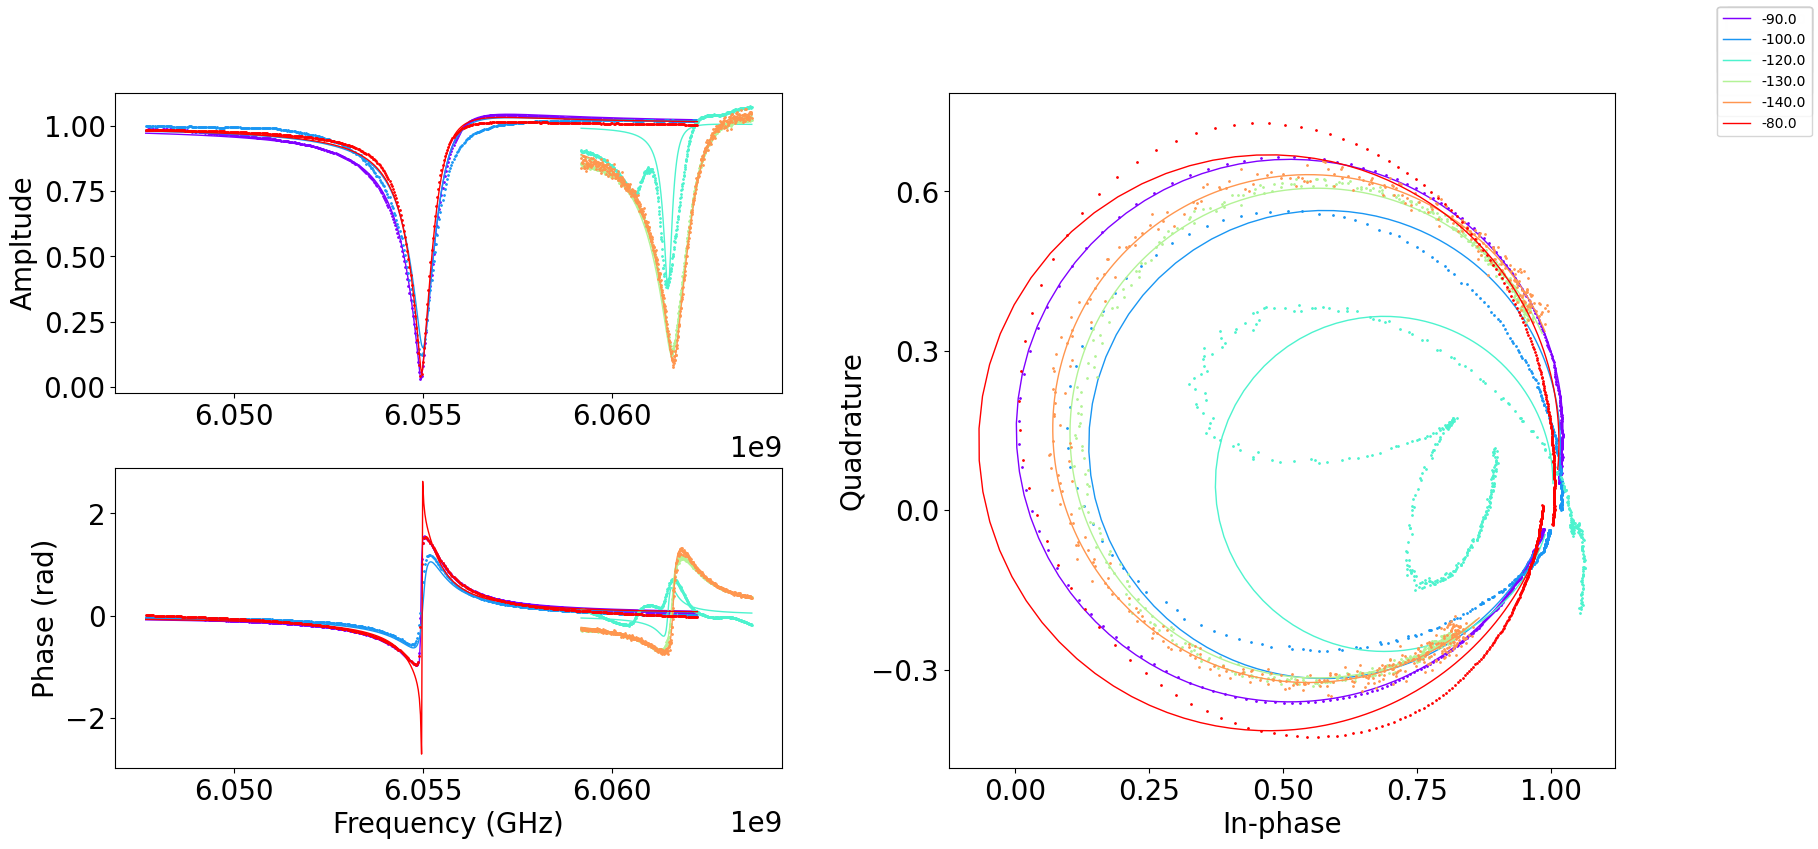

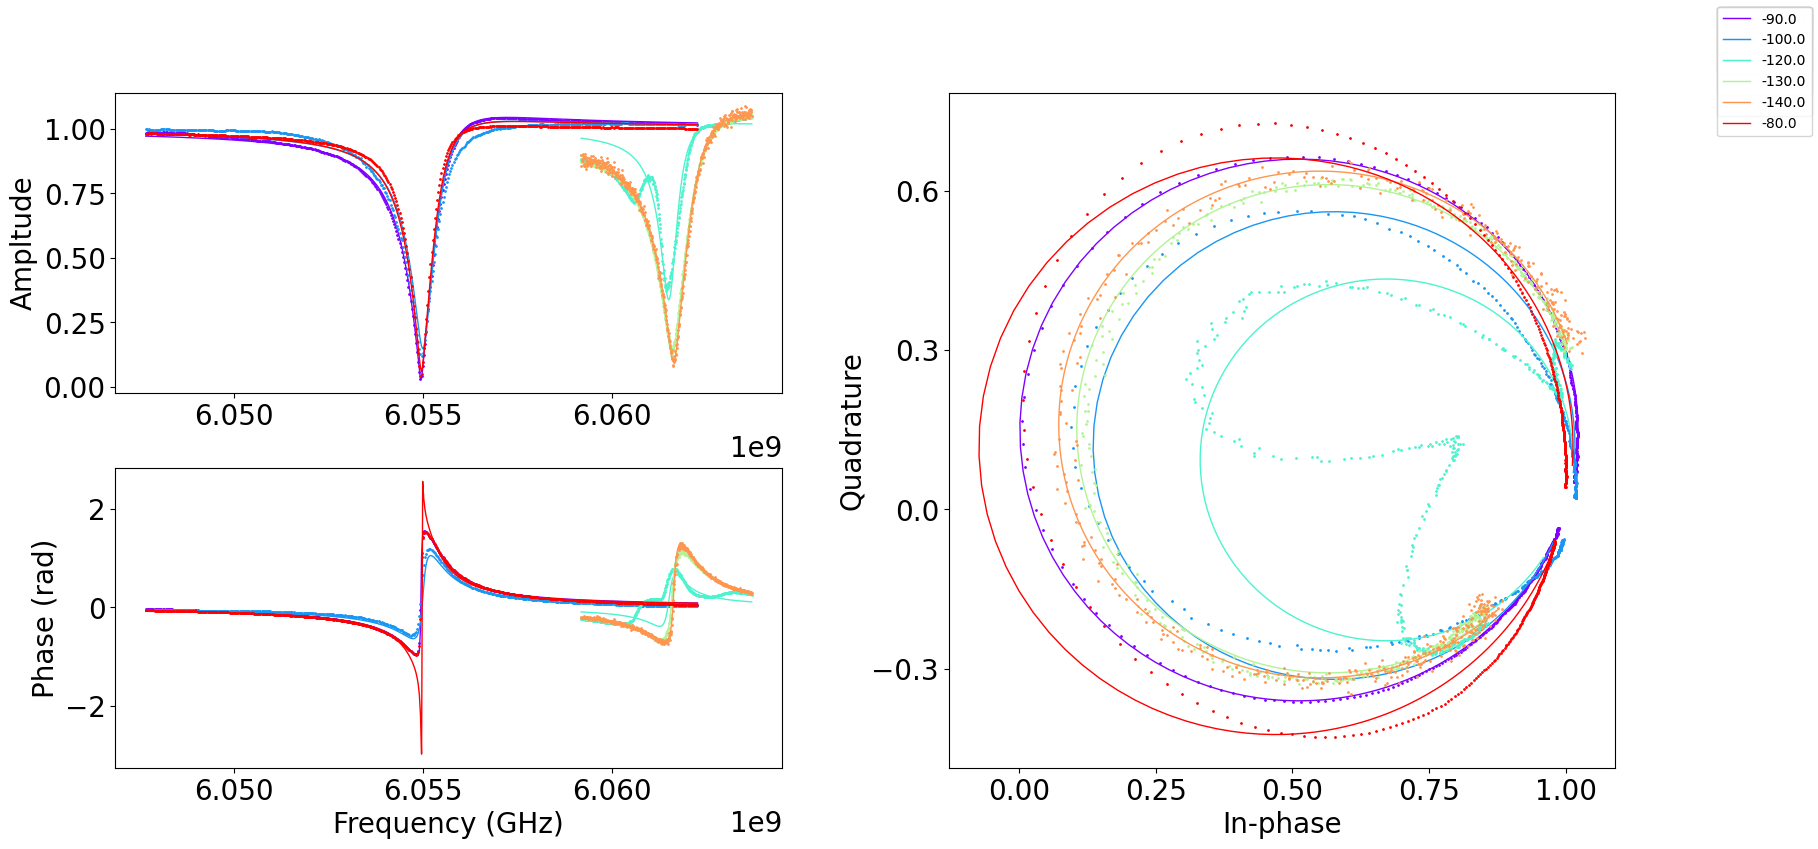

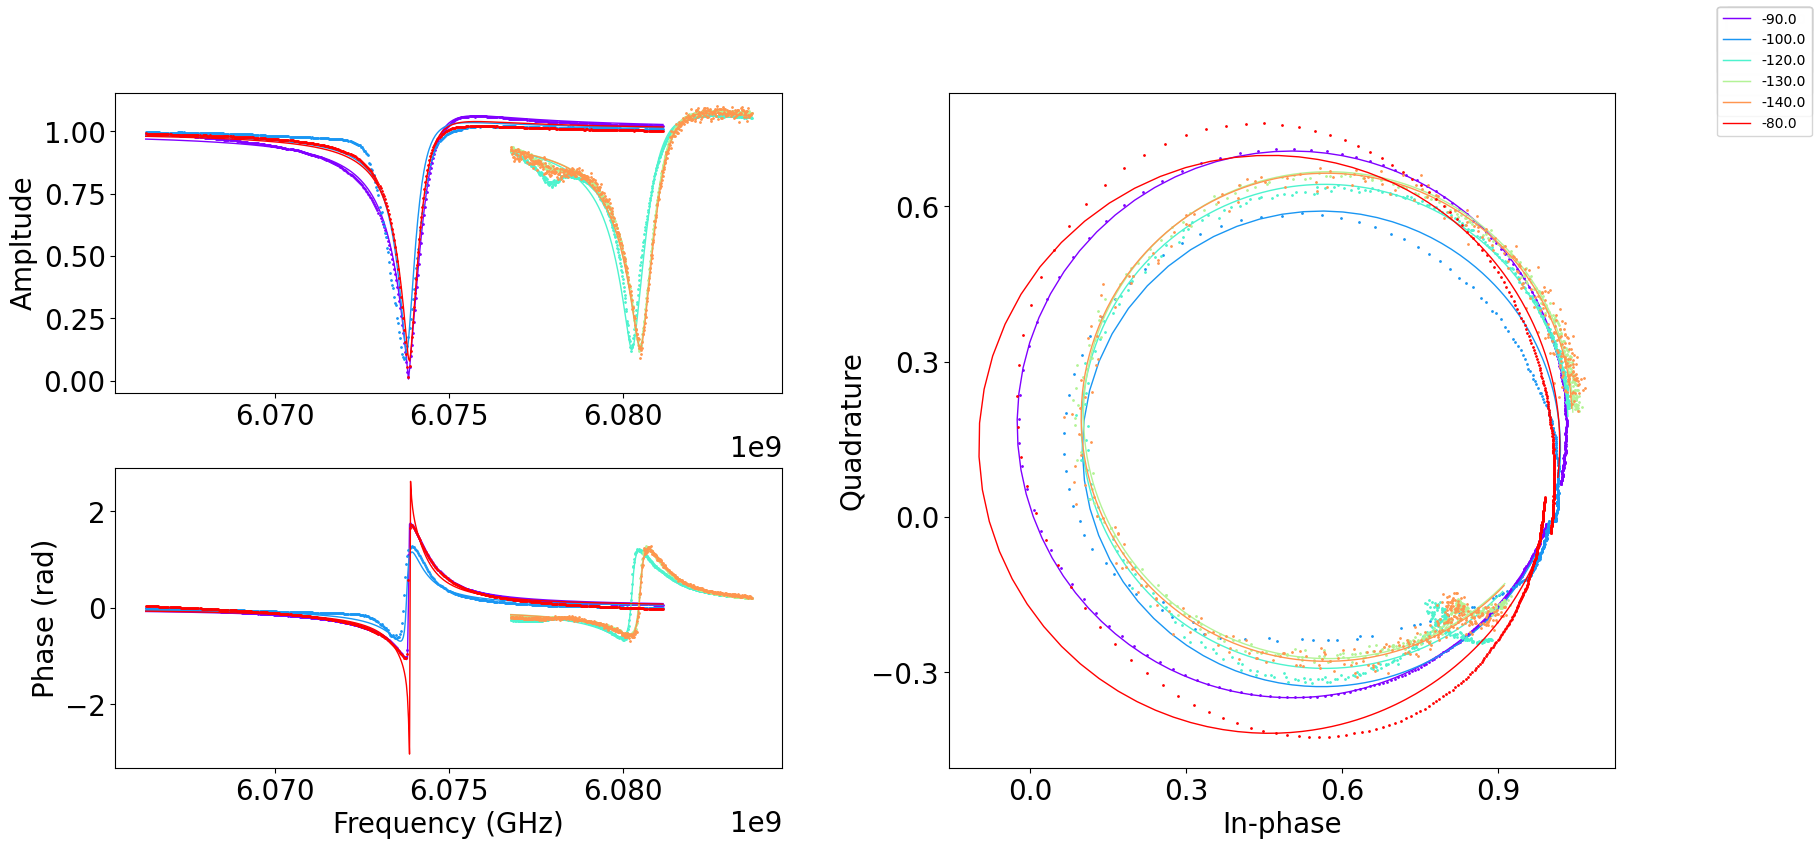

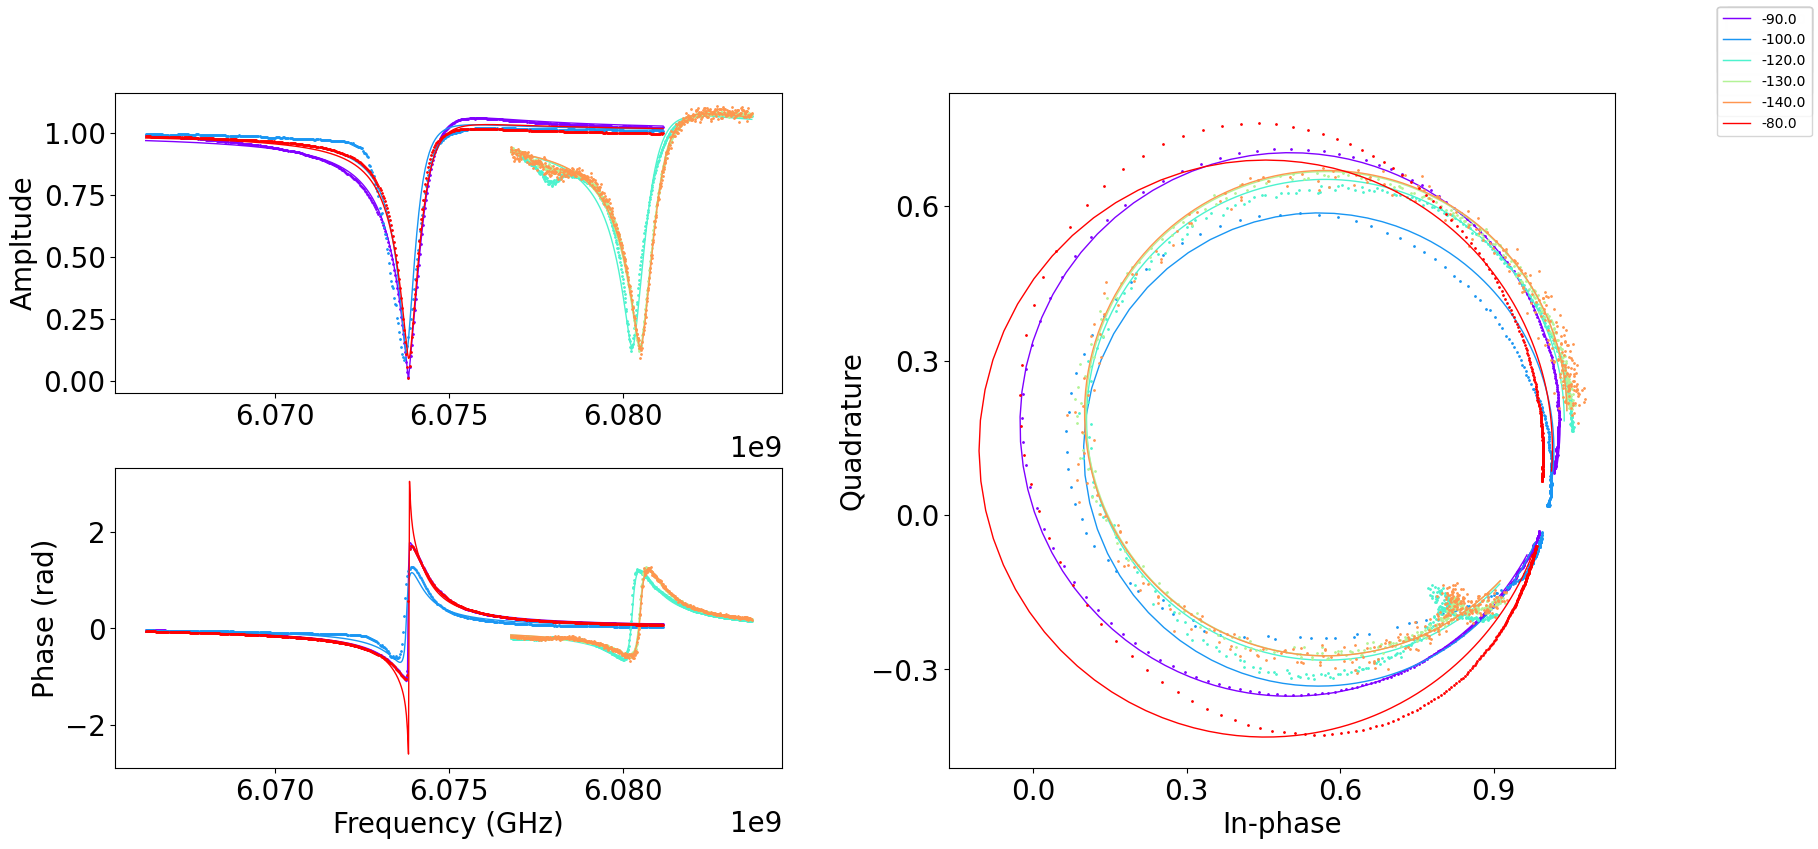

In [ ]:
from qcat.analysis.resonator.photon_dep.res_data import *
from qcat.utility.file_structure import check_file_extension, create_subfolder


# Get all resonator from folder
resonator_list = [d for d in os.listdir(preprocess_data_fd) if os.path.isdir(os.path.join(preprocess_data_fd, d))]
# check_configure(f"{output_fd}", ["power_dep_fit"])
# resonator_list = ["C48398"]
all_resonator_result = []

for resonator_label in resonator_list:
    print(f"Processing {resonator_label}")

    create_subfolder(output_fd,resonator_label)
    result_folder = f"{output_fd}\\{resonator_label}"

    resonator_data_folder = f"{preprocess_data_fd}\\{resonator_label}"
    resonator = PhotonDepResonator(resonator_label)
    # Find cavity data (nc file) in the folder
    file_list = check_file_extension( resonator_data_folder, "nc")
    print(resonator_data_folder)
    print(file_list)
    # file_list = ['liteVNA_80_-15.0.nc', 'liteVNA_80_-20.0.nc', 'liteVNA_80_-25.0.nc', 'liteVNA_80_-30.0.nc', 'liteVNA_80_-35.0.nc', 'liteVNA_80_-40.0.nc', 'liteVNA_80_-45.0.nc', 'liteVNA_80_-50.0.nc', 'liteVNA_80_-55.0.nc', 'liteVNA_80_-60.0.nc','liteVNA_110_-30.0.nc', 'liteVNA_110_-35.0.nc', 'liteVNA_110_-40.0.nc', 'liteVNA_110_-41.0.nc', 'liteVNA_110_-42.0.nc', 'liteVNA_110_-43.0.nc', 'liteVNA_110_-44.0.nc', 'liteVNA_110_-45.0.nc']

    for f_name in file_list:
        dataset = xr.open_dataset(f"{resonator_data_folder}\\{f_name}")
        power = dataset.attrs["power"]
        attenuation = dataset.attrs["attenuation"]
        frequency = dataset.coords["frequency"].values
        data = dataset["s21"].values
        resonator.import_array(frequency, data[0]+1j*data[1], power-attenuation)
    result = resonator.refined_analysis( result_folder )
    # result = resonator.free_analysis( result_folder )

    all_resonator_result.append( result )
    
    df_results = pd.concat(all_resonator_result)
    df_results.Name = resonator_label



Plot

In [ ]:

all_resonator_result = []
folder_list = [d for d in os.listdir(preprocess_data_fd) if os.path.isdir(os.path.join(preprocess_data_fd, d))]

fr = []
qc = []
for resonator_label in folder_list:
    create_subfolder(output_fd,resonator_label)
    result_folder = f"{output_fd}\\{resonator_label}"

    # Plotting
    df_powerQ_free = pd.read_csv( f"{plot_data_fd}\\{resonator_label}\\free_result.csv" )
    plot_singleRes_powerQ_free(df_powerQ_free, cav_label=f"{resonator_label}", output_fd=result_folder)
    plot_singleRes_powerloss_free(df_powerQ_free, cav_label=f"{resonator_label}", output_fd=result_folder)

    df_powerQ_refined = pd.read_csv( f"{plot_data_fd}\\{resonator_label}\\refined_result.csv" )
    plot_singleRes_powerQ_refined(df_powerQ_refined, cav_label=f"{resonator_label}", output_fd=result_folder)
    plot_singleRes_powerloss_refined(df_powerQ_refined, cav_label=f"{resonator_label}", output_fd=result_folder)
    fr.append(df_powerQ_refined["fr"].values[-1])
    qc.append(df_powerQ_refined["Qc_dia_corr_fixed"].values[-1])



c:\users\ke lab\documents\github\qcat\src\qcat\visualization\photon_dep_loss.py:620: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axObj.legend()
c:\users\ke lab\documents\github\qcat\src\qcat\visualization\photon_dep_loss.py:620: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axObj.legend()
c:\users\ke lab\documents\github\qcat\src\qcat\visualization\photon_dep_loss.py:620: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axObj.legend()
c:\users\ke lab\documents\github\qcat\src\qcat\visualization\photon_dep_loss.py:620: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start wi

ploting C58876
ploting C59414
ploting C59818
ploting C60477
ploting C60663
ploting C58876
ploting C59414
ploting C59818
ploting C60477
ploting C60663
ploting C58876
ploting C59414
ploting C59818
ploting C60477
ploting C60663
ploting C58876
ploting C59414
ploting C59818
ploting C60477
ploting C60663
ploting C58876
ploting C59414
ploting C59818
ploting C60477
ploting C60663
ploting C58876
ploting C59414
ploting C59818
ploting C60477
ploting C60663


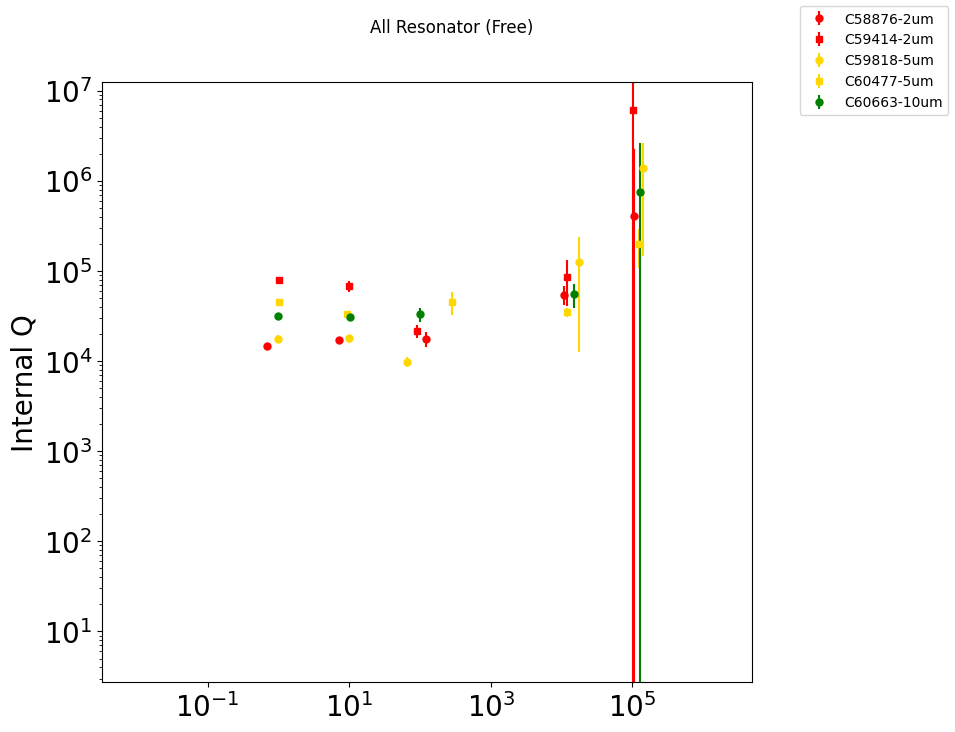

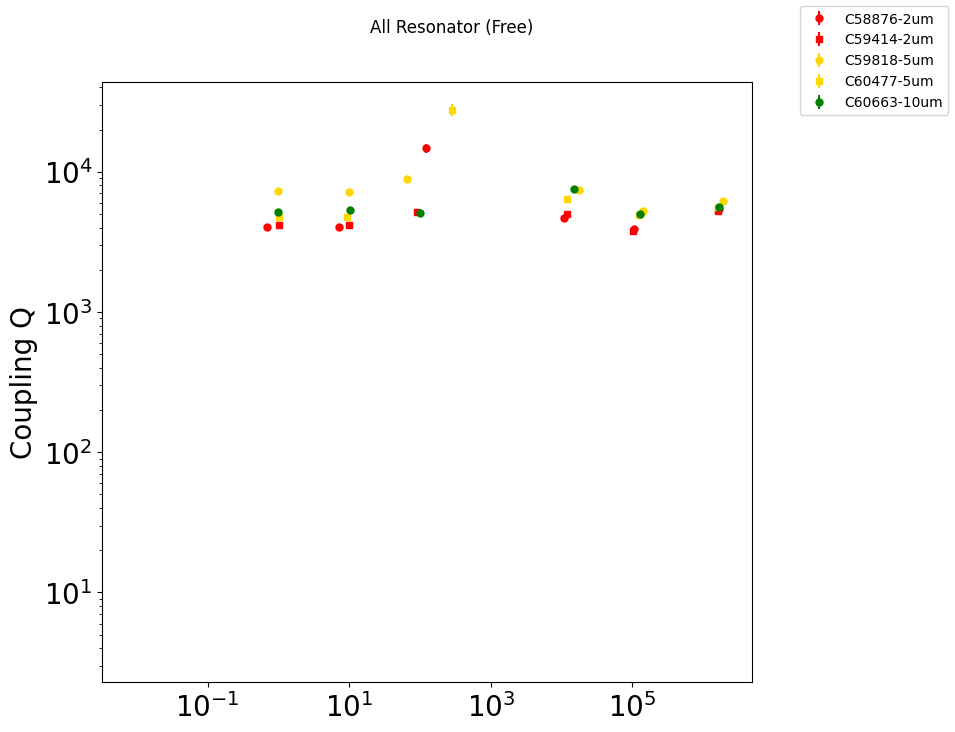

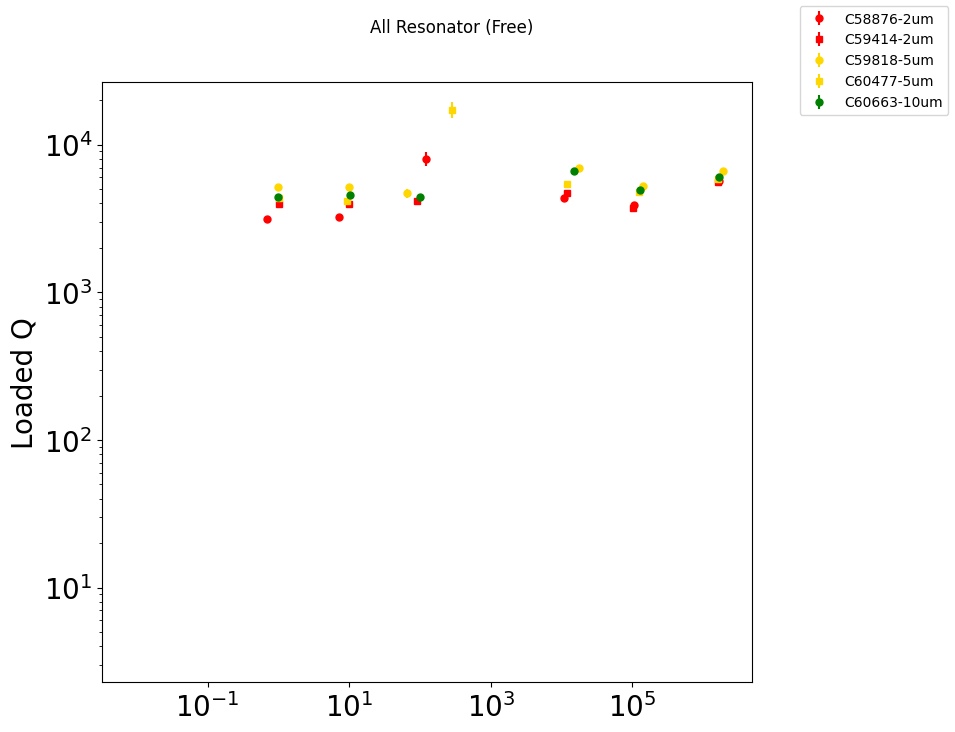

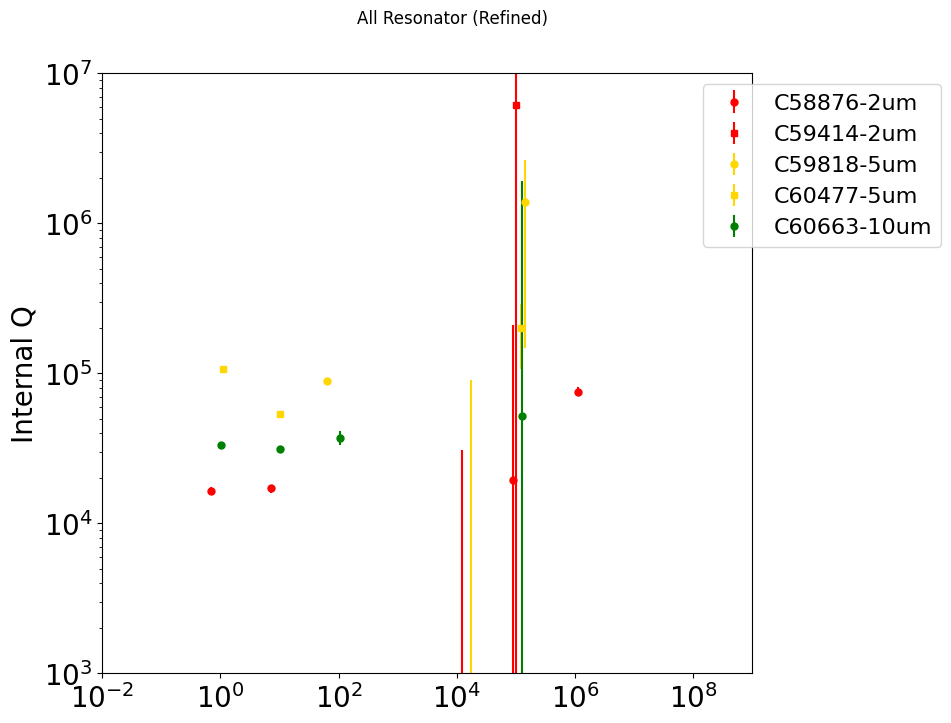

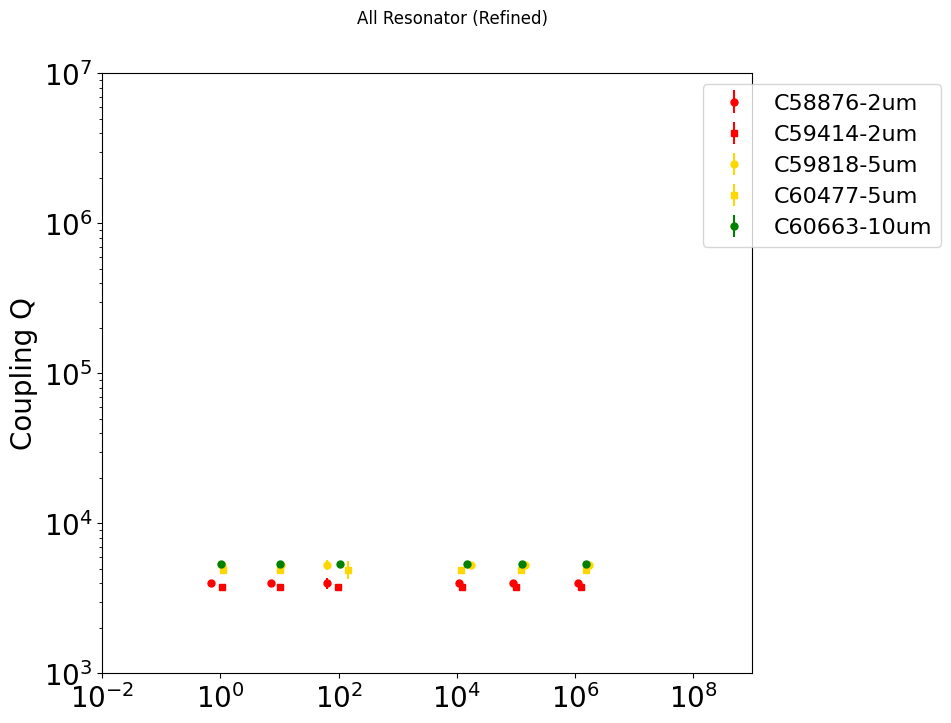

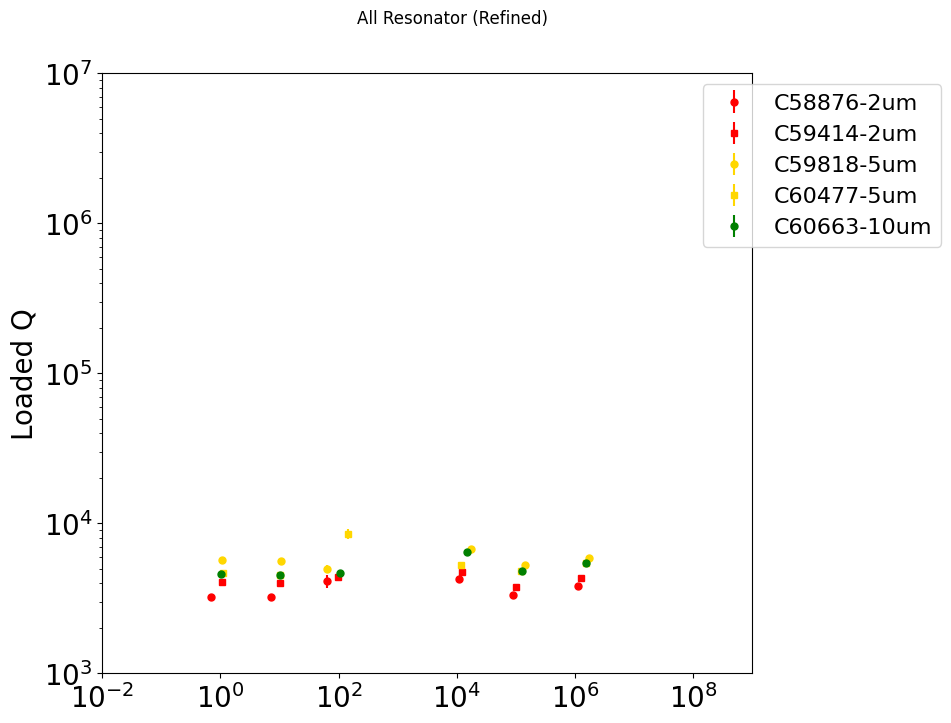

In [ ]:
## After assignment each cavity, get foward analysis
assignment = pd.read_json(r"C:\Users\Ke Lab\Desktop\YUHOW\5Q4C_0430_7\result\assignment.json")
plot_multiRes_powerQ_free( output_fd, assignment, output_fd)
plot_multiRes_powerQ_refined( output_fd, assignment, output_fd,((1e-2,1e9),(1e3,1e7)) )
# ((3e-1,3e5),(1e5,5e6))
pd.DataFrame({"fr":np.array(fr),"Qc":np.array(qc)}).to_csv( f"{output_fd}/Qc.csv" )

C:\Users\Ke Lab\AppData\Local\Temp\ipykernel_17300\3097970073.py:75: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(
C:\Users\Ke Lab\AppData\Local\Temp\ipykernel_17300\3097970073.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fitting_results = pd.concat([fitting_results, new_row], ignore_index=True)


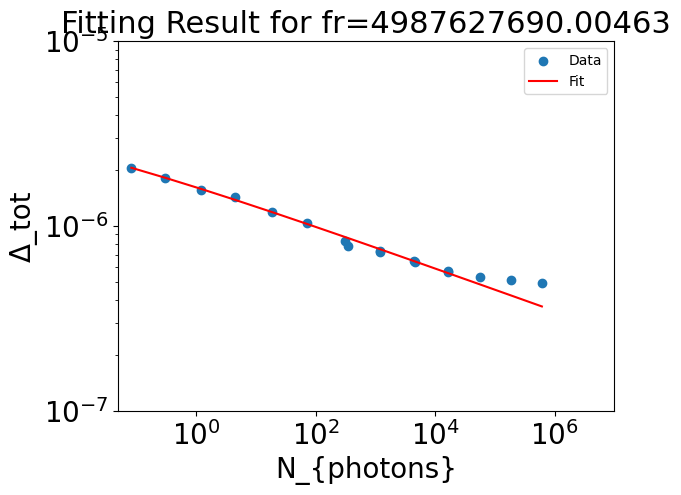

所有擬合結果已保存至 C:\Users\Ke Lab\Downloads\Send Anywhere (2024-11-07 16-49-54)\20241105_3FQ3CQ_1018_#5_Postbandage\fitting_results_new.csv


In [25]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
"""Fill in"""

# 設定結果資料夾的路徑
result_folder = r"C:\Users\Ke Lab\Downloads\Send Anywhere (2024-11-07 16-49-54)\20241105_3FQ3CQ_1018_#5_Postbandage"  # 替換為你的result資料夾路徑
fitting_lower_bound=5*1e-2
fitting_upper_bound=1e7
xlim_lowest=fitting_lower_bound
xlim_highest=fitting_upper_bound
ylim_lowest=1e-7
ylim_highest=1e-5
""""""
# 定義擬合的公式
def model_func(N_photons, delta_TLS, N_sat, alpha, delta_0):
    # 確保 N_photons 和 N_sat 大於零
    N_photons = np.maximum(N_photons, 1e-10)  # 防止出現小於等於0的情況
    N_sat = max(N_sat, 1e-10)  # 防止 N_sat 為負數或零
    return delta_TLS / np.sqrt(1 + (N_photons / N_sat)**alpha) + delta_0


# 建立一個空的DataFrame來存儲所有擬合結果
fitting_results = pd.DataFrame(columns=['fr', 'delta_TLS', 'N_sat', 'alpha', 'delta_0'])

# 遍歷result資料夾內的所有子資料夾
for subdir, dirs, files in os.walk(result_folder):
    for file in files:
        if file == 'refined_result.csv':  # 檢查文件名稱
            file_path = os.path.join(subdir, file)
            
            # 讀取 CSV 文件
            df = pd.read_csv(file_path)
            
            # 提取數據
            Qi_dia_corr = df['Qi_dia_corr'].values
            photons = df['photons'].values
            Qi_dia_corr_err = df['Qi_dia_corr_err'].values  # 提取誤差數據

            # 根據 photons 排序
            sorted_indices = np.argsort(photons)
            photons_sorted = photons[sorted_indices]
            Qi_dia_corr_sorted = Qi_dia_corr[sorted_indices]
            Qi_dia_corr_err_sorted = Qi_dia_corr_err[sorted_indices]
            
            # 計算 delta_tot
            delta_tot = 1 / Qi_dia_corr_sorted

            # 設置初始猜測值
            delta_0_initial = np.min(delta_tot)
            delta_TLS_initial = np.max(delta_tot) - delta_0_initial
            alpha_initial = 1.0  # 在 0 到 2 之間選擇一個值
            N_sat_initial = 1e0  # 假設的初始值

            # 提取 fr 欄位的第一個值
            fr_value = df['fr'].iloc[0]

            # 限制擬合範圍，這裡可以修改條件來選擇你要的數據點範圍
            fitting_mask = (photons_sorted >fitting_lower_bound) & (photons_sorted < fitting_upper_bound)  # 範例條件：限制 photons 在 10^2 到 10^7 之間
            photons_fit = photons_sorted[fitting_mask]
            delta_tot_fit = delta_tot[fitting_mask]
            Qi_dia_corr_err_fit = Qi_dia_corr_err_sorted[fitting_mask]

            # 確保有有效的數據進行擬合
            valid_mask = ~np.isnan(delta_tot_fit) & ~np.isnan(photons_fit) & ~np.isnan(Qi_dia_corr_err_fit)
            photons_fit = photons_fit[valid_mask]
            delta_tot_fit = delta_tot_fit[valid_mask]
            Qi_dia_corr_err_fit = Qi_dia_corr_err_fit[valid_mask]

            # 擬合數據，加權擬合使用誤差的倒數平方
            if len(photons_fit) > 0:  # 確保有足夠的數據點進行擬合
                try:
                    popt, pcov = curve_fit(
                        model_func,
                        photons_fit,
                        delta_tot_fit,
                        p0=[delta_TLS_initial, N_sat_initial, alpha_initial, delta_0_initial],
                        sigma=Qi_dia_corr_err_fit,
                        absolute_sigma=True
                    )
                    delta_TLS, N_sat, alpha, delta_0 = popt

                    # 保存擬合結果
                    new_row = pd.DataFrame({
                        'fr': [fr_value],
                        'delta_TLS': [delta_TLS],
                        'N_sat': [N_sat],
                        'alpha': [alpha],
                        'delta_0': [delta_0]
                    })
                    fitting_results = pd.concat([fitting_results, new_row], ignore_index=True)
                    
                    # 可選: 畫出每個擬合結果
                    fitted_delta = model_func(photons_fit, *popt)
                    plt.scatter(photons_sorted, delta_tot, label='Data')
                    plt.plot(photons_fit, fitted_delta, color='red', label='Fit')
                    plt.xscale('log')
                    plt.yscale('log')
                    plt.xlabel('N_{photons}')
                    plt.ylabel('Δ_tot')
                    plt.title(f'Fitting Result for fr={fr_value}')
                    plt.legend()
                    
                    # 設定 X 軸和 Y 軸的上下限（可以根據你的數據需求進行調整）
                    plt.xlim(xlim_lowest, xlim_highest)  # 設置 X 軸顯示範圍為 10^2 到 10^7
                    plt.ylim(ylim_lowest, ylim_highest)  # 設置 Y 軸顯示範圍為 10^-10 到 10^-6

                    
                    plt.show()

                except RuntimeError as e:
                    print(f"Fitting failed for {file_path}: {e}")

# 將擬合結果保存到一個新的 CSV 文件
output_file = os.path.join(result_folder, 'fitting_results_new.csv')
fitting_results.to_csv(output_file, index=False)
print(f"所有擬合結果已保存至 {output_file}")

